In [24]:
import pandas as pd
import numpy as np
import re #Regex lib
from forex_python.converter import CurrencyRates #currencies lib
from datetime import datetime
import matplotlib

### Read in the dataframes and create a dict {(year, dataframe)}


In [25]:
# Create a list of filenames for the datasets

data_frames_dict = {}

data_frames_dict[2017] = pd.read_csv('datasets/2017.csv', encoding = "ISO-8859-1").filter(items=['Country', 'Currency',  'Salary', 'YearsCodedJob']).dropna(thresh=4) 
data_frames_dict[2018] = pd.read_csv('datasets/2018.csv', encoding = "ISO-8859-1").filter(items=['Country',  'ConvertedSalary', 'YearsCodingProf']).dropna(thresh=3) 
data_frames_dict[2019] = pd.read_csv('datasets/2019.csv', encoding = "ISO-8859-1").filter (items=['Country',  'CompTotal', 'YearsCodePro']).dropna(thresh=3) 
data_frames_dict[2020] = pd.read_csv('datasets/2020.csv', encoding = "ISO-8859-1").filter (items=['Country',  'CompTotal', 'YearsCodePro']).dropna(thresh=3) 
data_frames_dict[2021] = pd.read_csv('datasets/2021.csv', encoding = "ISO-8859-1").filter (items=['Country','CompTotal', 'YearsCodePro']).dropna(thresh=3) 


/usr/local/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Section 1: Salary preprocessing

### The following currencies were found in the datasets and could not be converted to their equivalent currency symbols

In [26]:
currency_dict = {'Australian dollars (A$)': 'AUD',
 'Bitcoin (btc)': 'btc',
 'Brazilian reais (R$)': 'BRL',
 'British pounds sterling (Â£)': 'GBP',
 'Canadian dollars (C$)': 'CAD',
 'Chinese yuan renminbi (Â¥)': 'CNY',
 'Euros (â\x82¬)': 'EUR',
 'Indian rupees (?)': 'INR',
 'Japanese yen (Â¥)': 'JPY',
 'Polish zloty (zl)': 'PLN',
 'Russian rubles (?)': 'RUB',
 'Singapore dollars (S$)': 'SGD',
 'South African rands (R)': 'ZAR',
 'Swiss francs': 'CHF',
 'U.S. dollars ($)': 'USD',
 'none\tCook Islands dollar': 'NZD'}

### Compute currency symbols and add them to the 'currency_dict'

In [27]:
#helper function to covert currency to its symbol 
def add_currencies_to_dict(currency, currency_dict):
        currency_symbol = re.findall(r'[ˆA-Z]{3}', currency )

        if currency_symbol:
            # redundnat to add symbol to a dict {symbol -> symbol}but helps to treat all currencies the same
            currency_dict[currency] = currency_symbol[0]
        else:
            if currency not in currency_dict:
                print("WARN: there is no conversion available for this currency {}".format(currency))


# go through the  'CurrencySymbol' column if exists, otherwise 'Currency' 
# add all currencies that are not NaN to the 'currency_dict'
for year , df in data_frames_dict.items():
    
    # Check if Currecny column is present in df
    if 'CurrencySymbol' in df:
        print("{} year dataframe has a 'CurrencySymbol' column ".format(year))
        for currency_symbol in df.CurrencySymbol:
            #check for NaN
            if not pd.isna(currency_symbol):
                # redundnat to add symbol to a dict {symbol -> symbol}but helps to treat all currencies the same
                currency_dict[currency_symbol] = currency_symbol
    elif 'Currency' in df:
        print("{} year dataframe has a 'Currency' column ".format(year))
        for currency in df.Currency:
            #check for NaN
            if not pd.isna(currency):
                # add to dict {currency -> currency_symbol}
                add_currencies_to_dict(currency, currency_dict)   
                

2017 year dataframe has a 'Currency' column 


### Preporcess the salary related columns (currency, salary, salary type etc ) for datasets

#### Auxilliary/helper methods for currency conversions

In [28]:

def convert_currency(amount, currency, factor):
    return available_currencies_for_conversion[currency] * amount * factor


currency_converter = CurrencyRates()
date = datetime(2017, 12, 31, 18, 36, 28, 151012)

available_currencies_for_conversion = currency_converter.get_rates('EUR', date)

available_currencies_for_conversion['EUR']  = 1

# Take care of outlier salaries 
# max montly income in euros
max_montly_salary = 20000

# minimum mothly income in euros
min_montly_salary = 0

In [29]:
#Dictionary to hold processed payments/salary dataframes for yeas 2017 - 2021

clean_payment_dataframes_2017_to_2020 ={}

### Process 2017 payments

In [30]:
df_2017 = data_frames_dict[2017]

# annual salary divide by 12
annual_rate = float (1/12)


# for each currency entry, replace it with its currency symbol
df_2017.Currency = df_2017.Currency.apply(lambda x: currency_dict[x])


# Filter out the currencies that we cannot convert
df_2017 = df_2017[df_2017.Currency.apply(lambda c:   c  in available_currencies_for_conversion)]
    
# Covert salary to a euros and divide it by 12  
df_2017['Monthly_Sal_EUR'] = df_2017.apply(lambda row : convert_currency(row['Salary'],
                     row['Currency'], annual_rate), axis = 1)

# drop Currency, Salary columns 
# drop c salaries less than min_salary and greater than max salary 
df_2017 = df_2017.drop(['Currency','Salary' ], axis=1)
df_2017 = df_2017[(df_2017.Monthly_Sal_EUR > min_montly_salary) & (df_2017.Monthly_Sal_EUR < max_montly_salary)]

# process years of experience (find the years in the experience description and take the least number)
df_2017.YearsCodedJob = df_2017.YearsCodedJob.apply(lambda experience:   min(map(lambda s: int(s), re.findall(r'\d+', experience)), default=np.nan))

#rename YearsCodedJob to YearsCodePro
df_2017.columns = df_2017.columns.str.replace("YearsCodedJob","YearsCodePro")

#drop any NA 
df_2017= df_2017.dropna(thresh=3)

clean_payment_dataframes_2017_to_2020[2017] = df_2017
df_2017

/var/folders/h2/9wb_tlwj1bd2smbvq_25k5z4097jdb/T/ipykernel_5511/4268674995.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017['Monthly_Sal_EUR'] = df_2017.apply(lambda row : convert_currency(row['Salary'],


,Country,YearsCodePro,Monthly_Sal_EUR
2,United Kingdom,20.0,8410.201042
14,United Kingdom,20.0,7393.583333
17,United States,20.0,12992.416667
18,United States,3.0,8245.187500
22,Israel,5.0,10070.522100
...,...,...,...
51371,Netherlands,5.0,6182.795699
51378,Cyprus,5.0,8960.573477
51382,France,1.0,2688.172043
51387,United States,1.0,5796.616667


### Process 2018 payments

In [31]:
df_2018 = data_frames_dict[2018]

print(df_2018.head())

# convert the converted annual USD salary to monthly salary 
df_2018['Monthly_Sal_EUR'] = df_2018.apply(
    lambda row : convert_currency(row['ConvertedSalary'],'USD', annual_rate), axis = 1)

# We are no longer interested in the ConvertedSalary
# Also drop outlier salaries 
df_2018 = df_2018.drop('ConvertedSalary', axis=1)[(df_2018.Monthly_Sal_EUR > min_montly_salary) & (df_2018.Monthly_Sal_EUR < max_montly_salary)]

df_2018.YearsCodingProf = df_2018.YearsCodingProf.apply(lambda experience:   min(map(lambda s: int(s), re.findall(r'\d+', experience)), default=np.nan))

# rename YearsCodingProf to YearsCodePro
df_2018.columns = df_2018.columns.str.replace("YearsCodingProf","YearsCodePro")

# drop any NA at this point 
df_2018= df_2018.dropna(thresh=3)

clean_payment_dataframes_2017_to_2020[2018] = df_2018
df_2018

          Country  ConvertedSalary YearsCodingProf
1  United Kingdom          70841.0     18-20 years
4    South Africa          21426.0       0-2 years
5  United Kingdom          41671.0       3-5 years
6   United States         120000.0       0-2 years
8   United States         250000.0     21-23 years


,Country,YearsCodePro,Monthly_Sal_EUR
1,United Kingdom,18,7079.967608
4,South Africa,0,2141.350150
5,United Kingdom,3,4164.669192
6,United States,0,11993.000000
17,Sweden,0,4787.605600
...,...,...,...
87235,Kyrgyzstan,0,1559.090000
87239,Armenia,0,499.708333
87246,Pakistan,0,325.010300
87259,Argentina,0,2398.600000


### Covert 2019 - 2021 - these data frames have the same salary related columns 

In [32]:
df_2019_2021 = [data_frames_dict[2019], data_frames_dict[2020], data_frames_dict[2021]]
years = [2019, 2020, 2021]

annual_rate = 1/12

for year in years:
    df = data_frames_dict[year]

    # convert the converted annual USD salary to monthly salary 
    df['Monthly_Sal_EUR'] = df.apply(
        lambda row : convert_currency(row['CompTotal'],'USD', annual_rate), axis = 1)
    
    # drop CompTotal column
    # Also drop outlier salaries 
    df = df.drop('CompTotal', axis=1)[(df.Monthly_Sal_EUR > min_montly_salary) & (df.Monthly_Sal_EUR < max_montly_salary)]
    df.YearsCodePro = df.YearsCodePro.apply(lambda experience:   min(map(lambda s: int(s), re.findall(r'\d+', experience)), default=np.nan))
    df= df.dropna(thresh=3)
    print(df.head())
    clean_payment_dataframes_2017_to_2020[year] = df
    


          Country  YearsCodePro  Monthly_Sal_EUR
2        Thailand             1      2298.658333
3   United States             1      6096.441667
5          Canada             3      3997.666667
8     New Zealand             4     13791.950000
12  United States             8      8994.750000
           Country  YearsCodePro  Monthly_Sal_EUR
7    United States            13     11593.233333
9   United Kingdom             4      2498.541667
10  United Kingdom             2      3098.191667
11           Spain             7       109.935833
12     Netherlands            20       299.825000
    Country  YearsCodePro  Monthly_Sal_EUR
9    Sweden             4      4197.550000
11    Spain             5      4297.491667
12  Germany             6      7145.829167
16   Turkey             2       899.475000
17   Canada             6      6096.441667


In [33]:
def experience_mapper(experience):
    
    try:
        experience = int(experience)
        if experience <= 2:
            return 1.5 
        elif experience >= 3 and experience <= 5:
            return 4
        elif experience >= 6 and experience <= 8:
            return 7
        elif experience >= 9 and experience <= 11:
            return  10 
        elif experience >= 12 and experience <= 14:
            return 13 
        elif experience >= 15 and experience <= 17:
            return  16
        elif experience >= 18 and experience <= 20:
            return 19
        elif experience >= 21:
            return 20
        else:
            raise Exception("Invalid {} experience - : {}".format(type(exerience), experience))
    except ValueError: 
        if isinstance(experience, str):
               if experience == '0-2 years':
                return 1.5
               elif experience ==  'Less than a year':
                return 1.5
               elif experience == '1 to 2 years':
                return 1.5
               elif experience ==  'Less than 1 year':
                return 1.5
               elif experience == '2 to 3 years':
                return 4
               elif experience == '3 to 4 years':
                return 4
               elif experience == '3-5 years':
                return 4
               elif experience == '4 to 5 years':
                return 4
               elif experience ==  '5 to 6 years':
                return 4
               elif experience == '6 to 7 years':
                return 7
               elif experience == '7 to 8 years': 
                return 7
               elif experience ==  '6-8 years':
                return  7
               elif experience == '8 to 9 years':
                return  7  
               elif experience ==  '9 to 10 years':
                return 10
               elif experience == '10 to 11 years':
                return 10
               elif experience == '9-11 years':
                return 10
               elif experience ==  '11 to 12 years':
                return 10
               elif experience ==  '12 to 13 years':
                return 13
               elif experience == '13 to 14 years':
                return 13
               elif experience == '12-14 years':
                return 13
               elif experience ==  '14 to 15 years':
                return 13
               elif experience == '15 to 16 years':
                return 16
               elif experience == '15-17 years':
                return  16
               elif experience == '16 to 17 years':
                return  16
               elif experience == '17 to 18 years':
                return  16
               elif experience ==  '18 to 19 years':
                return 19
               elif experience == '19 to 20 years':
                return 19
               elif experience == '18-20 years':
                return 19
               elif experience ==  '20 or more years':
                return 20
               elif experience == '> 20 years':
                return 20   
               elif experience == '21-23 years':
                return 20
               elif experience == '24-26 years':
                return 20
               elif experience == '27-29 years':
                return 20
               elif experience == '30 or more years':
                return 20
               elif experience == 'More than 50 years':
                return 20
               else:
                raise Exception("Invalid experience: {}".format(experience))

### Compute a summary pdf - average of montly salaries per country 

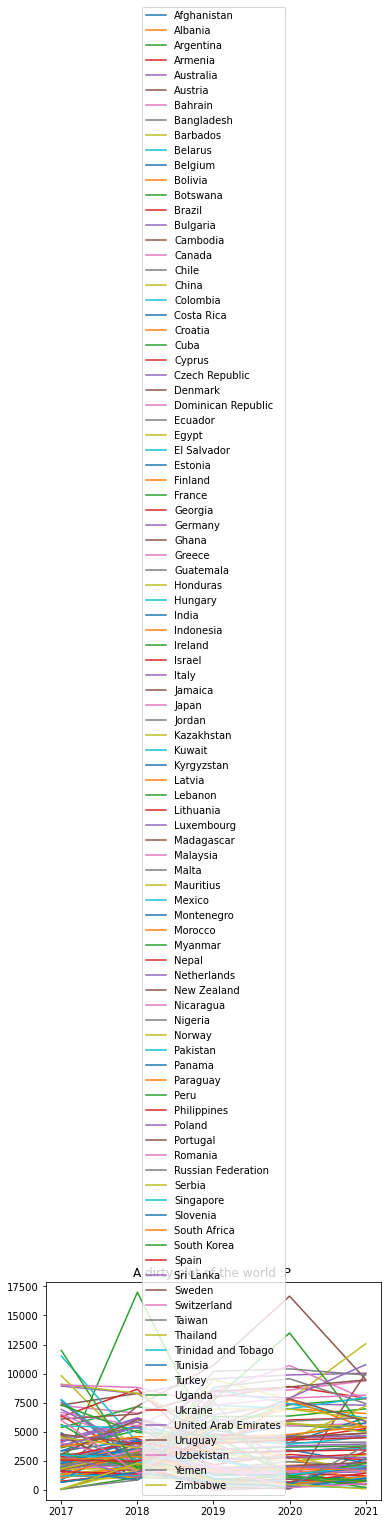

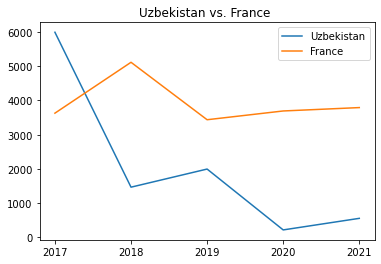

In [34]:
summary_df = None
i = 0
for year, df in clean_payment_dataframes_2017_to_2020.items():
    df = df.filter(items=['Country','Monthly_Sal_EUR'])
    
    # compute mean salary per country and reset the resulting df index
    df =  df.groupby('Country').mean().reset_index()
    
    # add column names 
    df.columns = ['Country', year]
    
    # merge the resulting dataframes into a single df columns = years, rows = countries
    if i > 0:
        summary_df = pd.DataFrame.merge(summary_df,df,on='Country')
        i+=1 
    else:
        summary_df =  df
        i+=1

# Transpose the summary_df, now  columns = countries and rows = years 
summary_df = summary_df.T

# Pick all the countries -> first row of the transposed matrix
column_names = summary_df.iloc[0]
column_names = list(column_names) 

# drop the first row containing countries' names, instead make the countries the column names 
summary_df = summary_df.drop('Country')
summary_df.columns = column_names

# You can finally do some simple plots 
summary_df.plot( xticks = [2017, 2018, 2019, 2020, 2021], title= "A dirty plot of the world :P ")
summary_df[['Uzbekistan','France'] ].plot( xticks = [2017, 2018, 2019, 2020, 2021], title = "Uzbekistan vs. France ")
summary_df.to_csv(path_or_buf = 'processed_data/salaries/average_montly_salary_in_Euros_per_country_per_year.csv', index=False)


In [35]:
summary_df

,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Barbados,Belarus,...,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,Uruguay,Uzbekistan,Yemen,Zimbabwe
2017,4919.021907,4607.000176,3121.053323,1907.220139,8936.402114,3812.167771,7495.625,3037.504866,2998.25,2399.74219,...,2998.25,669.112634,2607.618753,11993.0,2578.769931,3845.156769,4795.24828,5996.5,99.941667,69.959167
2018,875.863781,1744.905787,2840.876019,2425.392695,8282.282098,5553.443587,2940.08395,1539.602776,1827.13355,2620.184001,...,2780.57705,1541.176318,2867.951327,1860.293143,2483.344184,5378.025139,3985.473783,1464.806569,869.292617,2316.494077
2019,4397.47331,5401.558363,5263.906384,7972.013611,9545.273682,3122.711947,75.146139,6088.483639,349.795833,487.117308,...,2630.089885,587.819868,1691.696379,6167.40025,4018.830817,1837.638811,5412.183907,1994.744811,7620.552083,783.709236
2020,5639.797671,6991.550465,7322.781959,8897.306875,9889.99874,3318.580339,536.586808,5517.111949,417.656225,481.505624,...,1307.094226,310.342999,1803.289701,1223.286,4297.235843,2043.480351,7838.294484,214.374875,299.825,473.450932
2021,5071.24005,6578.083622,7841.236263,7902.054444,10038.868905,3704.04095,759.819014,5467.949308,2345.497661,850.183978,...,2036.992879,553.769762,1757.867338,228.937804,4494.867535,1764.934488,5909.048102,552.714895,3808.776917,113.518358


In [36]:
df = clean_payment_dataframes_2017_to_2020[2017]
df[df.Monthly_Sal_EUR > max_montly_salary]

,Country,YearsCodePro,Monthly_Sal_EUR


           Country  YearsCodePro
2   United Kingdom          20.0
14  United Kingdom          20.0
17   United States          20.0
18   United States           3.0
22          Israel           5.0
       Country  YearsCodePro
0  Afghanistan      9.000000
1      Albania      2.875000
2    Argentina      8.050000
3      Armenia      4.166667
4    Australia      8.958159
           Country  YearsCodePro
1   United Kingdom            18
4     South Africa             0
5   United Kingdom             3
6    United States             0
17          Sweden             0
       Country  YearsCodePro
0  Afghanistan      1.500000
1      Albania      2.181818
2      Algeria      3.125000
3      Andorra     22.500000
4    Argentina      6.405694
          Country  YearsCodePro
2        Thailand             1
3   United States             1
5          Canada             3
8     New Zealand             4
12  United States             8
       Country  YearsCodePro
0  Afghanistan      3.400000
1     

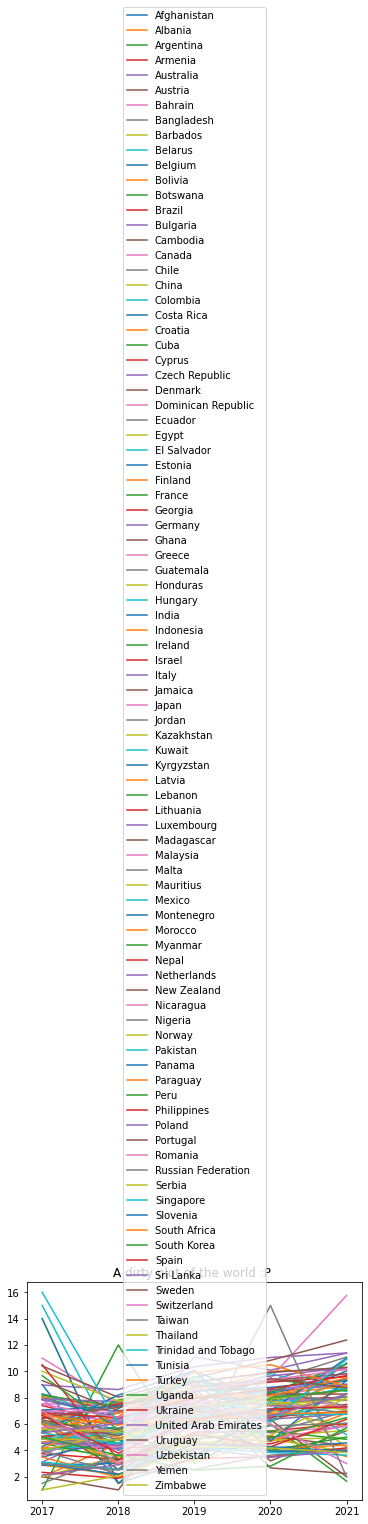

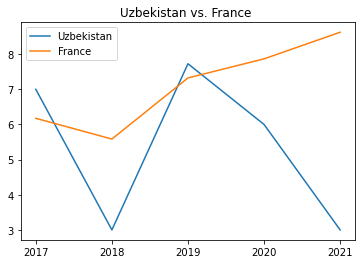

In [37]:
summary_df = None
i = 0
for year, df in clean_payment_dataframes_2017_to_2020.items():
    df = df.filter(items=['Country', 'YearsCodePro'] )
    print(df.head())
    # compute mean salary per country and reset the resulting df index
    df =  df.groupby('Country').mean().reset_index()
    print(df.head())

    # add column names 
    df.columns = ['Country', year]
    
    # merge the resulting dataframes into a single df columns = years, rows = countries
    if i > 0:
        summary_df = pd.DataFrame.merge(summary_df,df,on='Country')
        i+=1 
    else:
        summary_df =  df
        i+=1

# Transpose the summary_df, now  columns = countries and rows = years 
summary_df = summary_df.T

# Pick all the countries -> first row of the transposed matrix
column_names = summary_df.iloc[0]
column_names = list(column_names) 

# drop the first row containing countries' names, instead make the countries the column names 
summary_df = summary_df.drop('Country')
summary_df.columns = column_names

# You can finally do some simple plots 
summary_df.plot( xticks = [2017, 2018, 2019, 2020, 2021], title= "A dirty plot of the world :P ")
summary_df[['Uzbekistan','France'] ].plot( xticks = [2017, 2018, 2019, 2020, 2021], title = "Uzbekistan vs. France ")

summary_df.to_csv(path_or_buf = 'processed_data/experience/average_experience_per_country_per_year.csv', index=False)

In [38]:
summary_df


,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Barbados,Belarus,...,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,Uruguay,Uzbekistan,Yemen,Zimbabwe
2017,9.0,2.875,8.05,4.166667,8.958159,6.015625,11.0,6.222222,14.0,4.642857,...,16.0,3.0,6.666667,5.0,6.641026,5.333333,9.3,7.0,3.0,1.0
2018,1.5,2.181818,6.405694,4.166667,8.615599,6.828418,7.5,2.915888,1.5,4.475,...,6.0,2.172414,5.950549,3.631579,3.790588,6.056604,7.0,3.0,2.5,2.076923
2019,3.4,4.088889,7.917355,4.416667,10.34609,7.946322,6.1,4.645161,5.0,6.056911,...,9.625,4.481481,6.301848,2.5,6.359023,7.164557,7.619048,7.727273,4.0,4.266667
2020,6.421053,5.125,9.401869,4.5,11.050136,8.471154,9.5,3.988095,7.0,7.173333,...,6.142857,4.275862,6.776567,2.8,7.136519,6.615385,9.457627,6.0,15.0,4.181818
2021,10.625,3.538462,8.688312,6.0,11.391648,9.022321,15.75,4.085202,5.833333,7.291667,...,10.909091,3.929825,6.875,5.714286,7.303571,8.243902,8.754902,3.0,2.0,3.846154
